In [18]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from scipy.special import expit
from scipy.optimize import fmin, minimize
from sklearn.metrics import mean_squared_error
from scipy.stats import norm  
from math import sqrt
import glob as glob
import matplotlib
matplotlib.style.use('ggplot')


In [2]:
all_dengue = pd.read_csv("all-dengues.csv")

all_dengue.index = pd.DatetimeIndex(all_dengue.date)
all_dengue = all_dengue.drop(['date','date.1'],axis=1)
all_dengues = all_dengue.resample('W').size()
all_dengues_df = pd.DataFrame(all_dengues,columns=['cases'])

In [3]:
def split_data(data):
    train_mask = (data.index < "2011")
    train = data[train_mask]
    test_mask = (data.index > "2011")
    test = data[test_mask]
    return train, test

def remove_space(province):
    if type(province) == str:
        return province.replace(" ", "")

def guess(w,x):
    res = w[0]
    ws = w[1:]
    N = len(x)-1
    for i,ww in enumerate(ws):
        res += ww*x[N-i]
    return res

In [4]:
provinces_df = pd.read_csv("all-dengues.csv")
provinces_df.index = pd.DatetimeIndex(provinces_df.date)
provinces_df = provinces_df.drop(['date','date.1'],axis=1)

cr_dengues = provinces_df[provinces_df['จังหวัด'] == 'ChiangRai'].resample('W').size()
cr_dengues_df = pd.DataFrame(cr_dengues,columns=['cases'])
cr_train_test = split_data(cr_dengues_df)
cr_dengues_train, cr_dengues_test = cr_train_test[0], cr_train_test[1]

cm_dengues = provinces_df[provinces_df['จังหวัด'] == 'ChiangMai'].resample('W').size()
cm_dengues_df = pd.DataFrame(cm_dengues,columns=['cases'])
cm_train_test = split_data(cm_dengues_df)
cm_dengues_train, cm_dengues_test = cm_train_test[0], cm_train_test[1]

all_dengues = provinces_df.resample('W').size()
all_dengues_df = pd.DataFrame(all_dengues,columns=['cases'])
all_train_test = split_data(all_dengues_df)
all_dengues_train, all_dengues_test = all_train_test[0], all_train_test[1]

In [258]:
def get_two_std_away(cur_predicted_weeks):
    cur_week_data = cur_predicted_weeks
    cur_week_mean = cur_week_data.mean()
    cur_week_std = cur_week_data.std()
    two_std = (cur_week_std*3)
    lower_bnd, upper_bnd = cur_week_mean - two_std, cur_week_mean + two_std
    cur_week_data_df = pd.DataFrame(cur_week_data)
    two_std_mask = (cur_week_data_df >= lower_bnd) & (cur_week_data_df <= upper_bnd)
    out_of = (cur_week_data_df <= lower_bnd) | (cur_week_data_df >= upper_bnd)
    final_cur_week_data_df = pd.DataFrame(cur_week_data_df[two_std_mask])
    final_cur_week_data_df.columns = ['Percentage Away']
    final_cur_week_data_df = final_cur_week_data_df.dropna()
    out_of_df = pd.DataFrame(cur_week_data_df[out_of])
    out_of_df = out_of_df.dropna()
    return final_cur_week_data_df, out_of_df


In [83]:
def get_predictions(LAG, real, ws, nweeks_to_predict=[1]):

    def n_week_ahead(cases_for_prediction, weeks_ahead, case_week_to_predict):

        cur_prediction = 0
        prev_cases = np.array(cases_for_prediction.cases)
        for i in range(weeks_ahead):
            week_to_predict = case_week_to_predict + i
            cur_prediction = guess(ws, prev_cases)
            prev_cases = np.append(prev_cases[1:],cur_prediction) # deduct the first elm out
        return cur_prediction

    all_predictions = []
    for nweek in nweeks_to_predict: # 1,2,4,8,16
        predictions = []
        for start_week in range(len(real)-(LAG)):
            case_week_to_predict = start_week + LAG
            cases_for_prediction = real[start_week:case_week_to_predict]

            prediction = n_week_ahead(
                cases_for_prediction,
                nweek,
                case_week_to_predict)
            predictions.append(prediction)
        all_predictions.append(predictions)
    return all_predictions

In [84]:
def make_line(start_week,real,predictions,title,x_axis,y_axis,
              real_legend='Real',predict_legend='Prediction'):
    plt.figure(figsize=(12,6))
    plt.plot(range(len(real)),real,'-r',label=real_legend)
    plt.plot(range(start_week,len(predictions)+start_week),predictions,'-k',label=predict_legend,alpha=0.4)
    plt.axvline(start_week)
    plt.text((start_week*2)+10,400,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.title(title)
    
def seperate_train_test(all_data,train_data):
    plt.axvspan(0, len(train_data), color='blue', alpha=0.1)
    plt.text((len(train_data)/2)-25,600,'Train Period',size=16)
    plt.axvline(len(train_data)+1,linewidth=0.5, color='green')
    plt.text(len(train_data)+20,600,'Test Period',size=16)
    plt.axvspan(len(train_data)+1, len(all_data), color='green', alpha=0.1)
    
def plot_all_predictions(LAG, train, real, nweeks_to_predict, all_predictions):
    
    plt.figure(figsize=(13,6))
    plt.plot(range(len(real)),real,label='real')
    graph_title = "ChiangMai Dengue Prediction"
    plt.title(graph_title)
    for i in range(len(all_predictions)):
        cur_week_guess = nweeks_to_predict[i]
        start_predict_week = LAG+(cur_week_guess-1)
        predicted_cases = all_predictions[i]
        x_weeks = range(start_predict_week,len(predicted_cases)+start_predict_week)
        line_label = "%d week guess"%cur_week_guess
        plt.plot(x_weeks,predicted_cases,label=line_label,alpha=0.8)
    
    seperate_train_test(real,train)
    plt.axvline(LAG)
    plt.text((LAG*2)+10,400,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel("# week starting 2003")
    plt.ylabel("Dengue cases")
    plt.legend(loc='best')
#     plt.savefig("autoregression-chiangmai-dengue-cases-1-2-4-8-16.pdf",dpi = 300, bbox_inches='tight')
    
def show_predictions(LAG, train, real, ws):
    predictions_to_plot = get_predictions(LAG, real, ws)
    plot_all_predictions(LAG, train, real, [1], predictions_to_plot)

In [7]:
from scipy.optimize import fmin, minimize

def get_alphas(lag,train):
    
    np.random.seed(99)
    arr = np.random.randn(lag)
    
    def guess(w,x):
        res = w[0]
        ws = w[1:]
        N = len(x)-1
        for i,ww in enumerate(ws):
            res += ww*x[N-i]
        return res
    
                  # real is exp**D(ar) * pop
    def cost(w):  # (real - pred)**2 / N
#         return sum((np.log(train[i+lag]) - guess(w,train[i:i+(lag-1)]))**2 \
#                for i in range(len(train)-lag))/len(train)
    
        ret = 0
        for i in range(len(train)-lag):
            real = train[i+lag]
            pred = guess(w,train[i:i+(lag-1)])
            ret += (real-pred)**2
            
        print ret/float(len(train))
        return ret/float(len(train))
    
    w = minimize(cost,arr).x
    return w
    

In [7]:
# w_27 = get_alphas(27, cm_dengues_train.cases)

w_27 = [  
    6.49593304e+00,   1.22203276e+00,  -7.13411922e-02,
     1.13017063e-01,  -1.32779056e-02,  -2.74043062e-01,
    -2.21338178e-01,  -1.39505295e-01,   2.24147661e-01,
     4.09348045e-02,   3.96022598e-02,  -1.06229987e-01,
    -1.28692027e-02,   1.78564856e-01,  -8.93539197e-02,
    -7.59063095e-02,   9.06405514e-02,   6.02477815e-02,
    -9.27739077e-02,  -3.25537525e-03,   6.25954113e-02,
    -1.14721724e-01,  -2.09491503e-02,   6.82486254e-02,
    -7.22771350e-02,  -1.47781354e-02,   5.54734324e-02
        ]

In [569]:
w_27

array([  6.49593304e+00,   1.22203276e+00,  -7.13411922e-02,
         1.13017063e-01,  -1.32779056e-02,  -2.74043062e-01,
        -2.21338178e-01,  -1.39505295e-01,   2.24147661e-01,
         4.09348045e-02,   3.96022598e-02,  -1.06229987e-01,
        -1.28692027e-02,   1.78564856e-01,  -8.93539197e-02,
        -7.59063095e-02,   9.06405514e-02,   6.02477815e-02,
        -9.27739077e-02,  -3.25537525e-03,   6.25954113e-02,
        -1.14721724e-01,  -2.09491503e-02,   6.82486254e-02,
        -7.22771350e-02,  -1.47781354e-02,   5.54734324e-02])

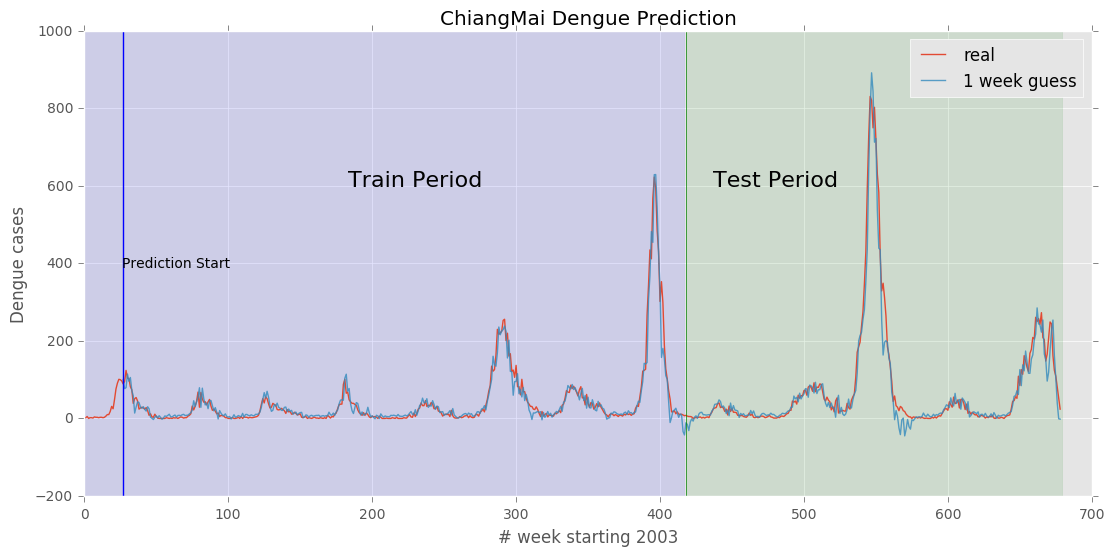

In [85]:
# a = get_predictions(27, all_dengues_df, w_27)
show_predictions(27, cm_dengues_train.cases, cm_dengues_df[:-52], w_27)

In [332]:
def get_distances(LAG, all_predictions, real):

    def distance(prediction, real):
        all_residual = prediction - real
        return all_residual

    weeks = [1]
    ret = []
    for idx,prediction in enumerate(all_predictions):
        cur_pred = np.array(prediction)
        # compare with real
        # doesnt take into the accout of the predicted week(s)
        cur_pred_range = cur_pred[:-weeks[idx]]
        real_range = real.cases[LAG+weeks[idx]:]
        ret.append(distance(cur_pred_range,real_range))

    return ret

def get_distances(all_predicitions, real):
    np_all_pred = np.array(all_predicitions)
    np_real = np.array(real)
    res = np_real - np_all_pred
    return np.array(res)

def get_distances_percent(all_predicitions, real):
    np_all_pred = np.array(all_predicitions)
    np_real = np.array(real)
    ret = []
    for idx,real_case in enumerate(np_real):
        if real_case >= 100:
            pred_case = np_all_pred[idx]
#             print pred_case, real_case
            score = real_case - pred_case
            percent_ = score/real_case
            ret.append(percent_)
    return np.array(ret)


In [410]:
weeks_ahead = [4]

cur_ws = w_27
cur_train = cm_dengues_train
cur_real = cm_dengues_df
cur_test = cm_dengues_test
    
predictions_to_validate = get_predictions(
        27,
        cur_test,
        cur_ws,
        weeks_ahead)


235 235


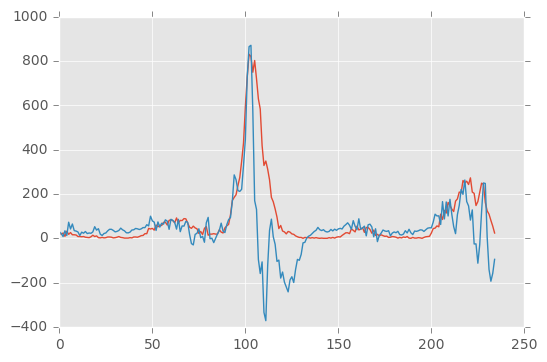

In [411]:
# np_train = np.array(cm_dengues_train.cases)[27:]
np_pred_test = np.array(predictions_to_validate[0])[:-52]
np_test = np.array(cm_dengues_test.cases)[27:-52]

print len(np_pred_test), len(np_test)

plt.plot(np_test)
plt.plot(np_pred_test)
# plt.xlim(90,100)
# plt.ylim(0,600)
# plt.axvline(92)
# plt.axhline(106)
# plt.axhline(76)

# print len(np_test), len(np_pred_test)
# plt.figure()
# plt.plot(percent_err)

In [358]:
percent_err = get_distances_percent(np_pred_test,np_test)

In [348]:
percent_err

array([ 0.29746048,  0.22540499, -0.25545161, -0.23530651,  0.00861543,
        0.06730718,  0.21741374,  0.20679589,  0.24491842,  0.05232115,
       -0.0203914 , -0.13401035, -0.10426439,  0.23731597,  0.25038418,
        0.48361408,  0.55710792,  0.34429469,  0.77853737,  1.08527087,
        0.80802625,  0.5499541 ,  0.08230013,  0.20359681,  0.40174832,
        0.37533431,  0.30364575, -0.33731557,  0.22275159, -0.19751439,
       -0.00959445,  0.08179029,  0.46288919,  0.24695375,  0.29594976,
       -0.04415803,  0.10915981, -0.14992689,  0.12965935,  0.09244813,
        0.29430732, -0.05781001,  0.4735037 ,  0.31459717,  0.79601876,
        0.67982309,  0.44980683,  0.04478093, -0.69281524, -0.20357047,
        0.709348  ])

In [412]:
real_err = get_distances(np_pred_test,np_test)

5.15285928303 24.9783195527


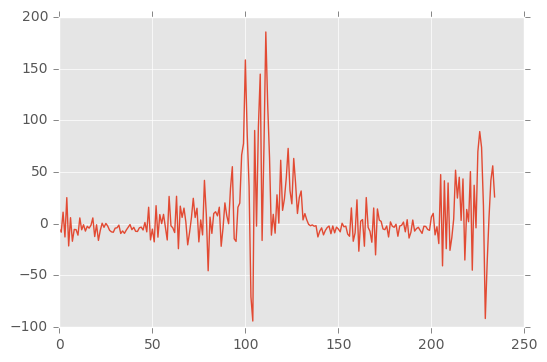

In [369]:
# cur_distance_away_data = real_err
# two_std_away_data_plot, outside_two_std = get_two_std_away(cur_distance_away_data)
# two_std_away_data = np.array(two_std_away_data_plot)

# (mu, sigma) = norm.fit(two_std_away_data)
# print mu,sigma
# plt.plot(real_err)

0.980392156863


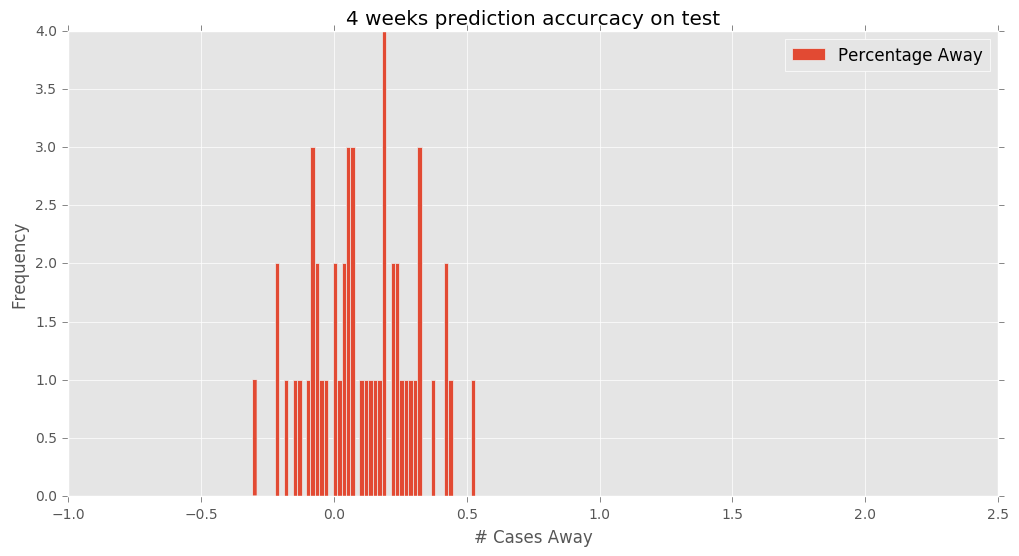

In [339]:
# real_err = get_distances(np_pred_test,np_test)
percent_err = get_distances_percent(np_pred_test,np_test)


# weeks_predicted = [1,2,4,8,16]
# for idx, week in enumerate(weeks_predicted):
cur_distance_away_data = percent_err
two_std_away_data, out_side = get_two_std_away(cur_distance_away_data)

title = "4 weeks prediction accurcacy on test"
two_std_away_data.plot(kind="hist",bins=50,title=title,figsize=(12,6))
plt.xlabel("# Cases Away")
plt.xlim(-1,2.5)
# plt.savefig("model-01-4-weeks-prediction-accuracy-test.pdf")
print len(two_std_away_data) / float(len(cur_distance_away_data))

two_std_away_data has size of 228
mean: 18.479287; std: 82.850363
0.970212765957
228 7 235


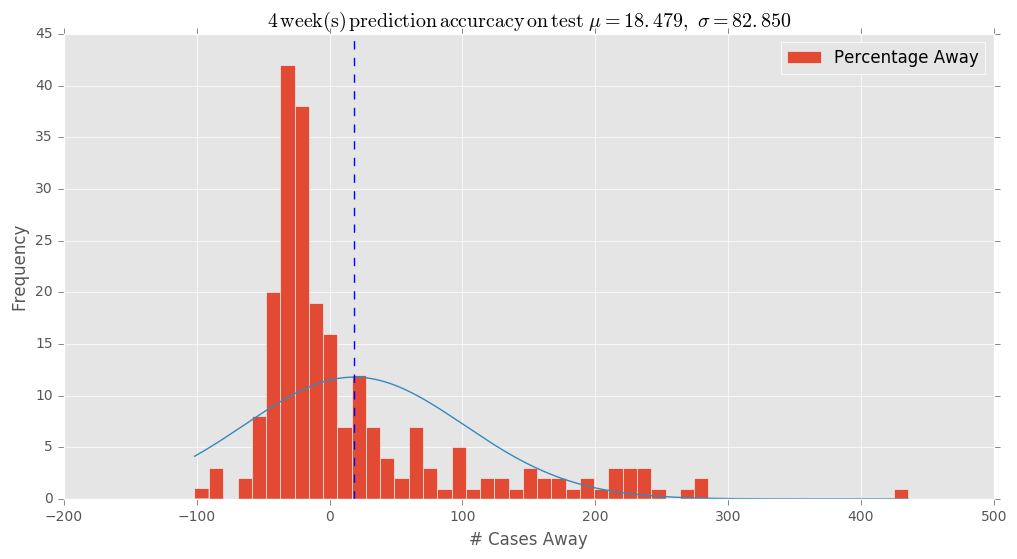

In [414]:
cur_distance_away_data = real_err
two_std_away_data_plot, outside_two_std = get_two_std_away(cur_distance_away_data)
two_std_away_data = np.array(two_std_away_data_plot)

(mu, sigma) = norm.fit(two_std_away_data)

n, bins, patches = plt.hist(two_std_away_data, 50, normed=1, alpha=0.75)
plt.close()
bin_width = bins[1] - bins[0]

week_to_predict = 4
title = r'$\mathrm{%d\,week(s)\,prediction\,accurcacy\,on\,test}\ \mu=%.3f,\ \sigma=%.3f$' %(week_to_predict,mu, sigma)
two_std_away_data_plot.plot(kind="hist",bins=50,title=title,figsize=(12,6)) # hist give bin size
plt.xlabel("# Cases Away")
range_ = np.arange(two_std_away_data.min(), two_std_away_data.max(), 0.001)
plt.plot(range_, norm.pdf(range_,two_std_away_data.mean(),two_std_away_data.std())*len(two_std_away_data)*bin_width)
plt.axvline(float(two_std_away_data.mean()),ls='--')
plt.xlim(-200,500)
# plt.savefig("model-01-4-weeks-prediction-accuracy-test-raw.pdf",dpi = 300, bbox_inches='tight')

print 'two_std_away_data has size of', len(two_std_away_data)
print 'mean: %f; std: %f'%(mu,sigma)
print len(two_std_away_data) / float(len(cur_distance_away_data))
print len(two_std_away_data),len(outside_two_std),len(cur_distance_away_data)
# print outside_two_std.max(),outside_two_std.min()

In [198]:
from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

cur_distance_away_data = percent_err
two_std_away_data, outside_two_std = get_two_std_away(cur_distance_away_data)
two_std_away_data = np.array(two_std_away_data)

(mu, sigma) = norm.fit(two_std_away_data)

n, bins, patches = plt.hist(two_std_away_data, 60, normed=1, alpha=0.75)
plt.close()
bin_width = bins[1] - bins[0]

# add a 'best fit' line
# y = mlab.normpdf( bins, mu, sigma)
# l = plt.plot(bins, y, '--', linewidth=2)

#plot
# plt.xlabel('Percentage Away')
# plt.ylabel('Probability')
# plt.title(r'$\mathrm{Histogram\ of\ Percentage:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))

In [197]:
for i in range(len(bins)-1):
    print bins[i+1] - bins[i]

0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638
0.030704359638


In [248]:
predictions_to_validate = get_predictions(
        27,
        cur_test,
        cur_ws,
        weeks_ahead)

train_to_validate = get_predictions(
        27,
        cur_train,
        cur_ws,
        weeks_ahead)

def RMSE(real, predicted):
    np_real, np_predicted = np.array(real), np.array(predicted)
    mse = mean_squared_error(np_real, np_predicted)
    score = sqrt(mse)
    return score

# print RMSE(cur_train[27:],train_to_validate[0])
# print RMSE(cur_test[27:],predictions_to_validate[0])

# plt.plot(train_to_validate[0])
# plt.plot(np_train)
# plt.figure()

# plt.plot(predictions_to_validate[0])
# plt.plot(np_test)
# # plt.xlim(285,290)
# plt.figure()
